In [1]:
import numpy as np
import pandas as pd
import mne
import glob
import os
from scipy.signal import resample
from matplotlib import pyplot as plt
from idun_sdk import do_bandpass, prepare_fft
from data_labeler import calculate_bad_epochs
from scipy.signal import find_peaks
import copy
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from utils.lag_calculator import calculate_lag, epoch_data, remove_outliers, replace_outliers, calculate_epochs_lag,prepare_prodigy_data,prepare_idun_data
import config
from scipy.signal import resample

### Upload all data

In [2]:
edf_file_path = glob.glob(os.path.join("data", '*.edf'))[0]
csv_file_path = glob.glob(os.path.join("data", '*.csv'))[0]
prodigy_raw_data = mne.io.read_raw_edf(edf_file_path, preload=True)
# upload csv file using numpy
idun_raw_data = np.genfromtxt(csv_file_path, delimiter=',', skip_header=1)

### Unpack prodigy data

In [3]:
prodigy_base_data_df, prodigy_filtered_data_rs, resampled_times = prepare_prodigy_data(prodigy_raw_data,config)
pr_freqs_rs, pr_fft_rs = prepare_fft(prodigy_filtered_data_rs, config.FILTER_RANGE[0]-5 ,config.FILTER_RANGE[1]+5, config.BASE_SAMPLE_RATE)
# print columns of the dataframe
print(prodigy_base_data_df.columns)

Index(['AUDIO', 'CHIN', 'LEFT_EEG', 'LEFT_EYE', 'MASTOID', 'POSITION',
       'RIGHT_EEG', 'RIGHT_EYE'],
      dtype='object')


(-200.0, 200.0)

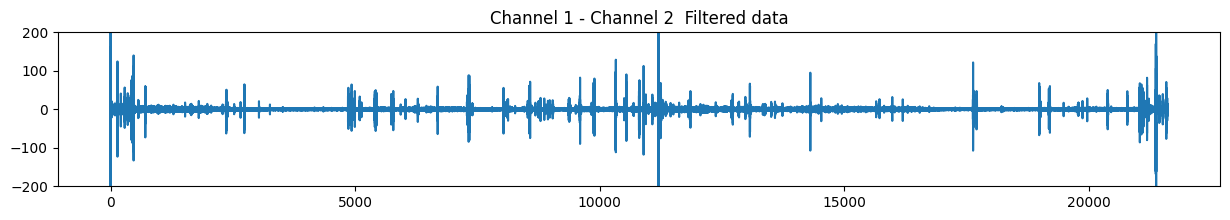

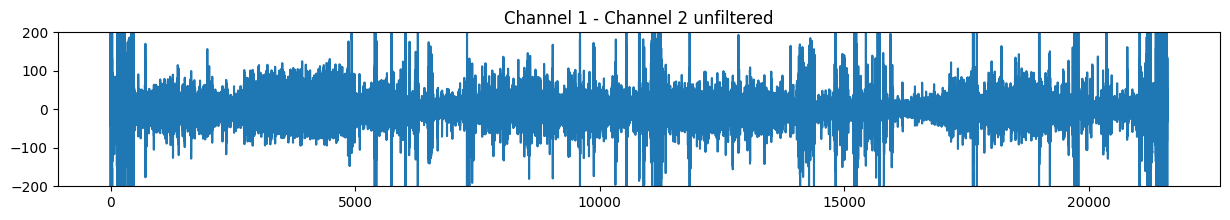

In [70]:
plt.figure(figsize=(15, 2))
plt.plot(resampled_times, prodigy_filtered_data_rs)
plt.title('Channel 1 - Channel 2  Filtered data')
plt.ylim(-200, 200)
# Plot the fft of the data
plt.figure(figsize=(15, 2))
plt.plot(resampled_times, (prodigy_base_data_df[config.CHANNEL_1] - prodigy_base_data_df[config.CHANNEL_2])*1000000 )
plt.title('Channel 1 - Channel 2 unfiltered')
plt.ylim(-200, 200)

### Unpack IDUN data

In [71]:
idun_base_data, idun_filtered_data, idun_time_stamps = prepare_idun_data(idun_raw_data,config)

Text(0.5, 1.0, 'IDUN Highpassed data')

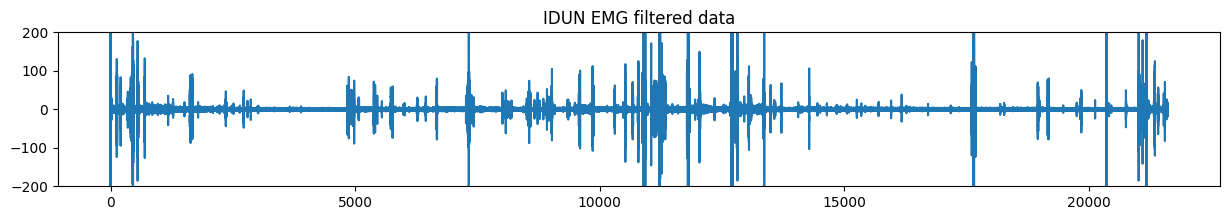

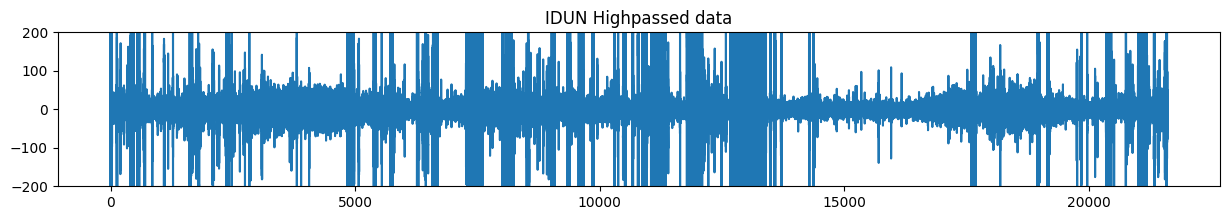

In [72]:
plt.figure(figsize=(15, 2))
plt.plot(idun_time_stamps, idun_filtered_data)
plt.ylim(-200, 200)
plt.title("IDUN EMG filtered data")

plt.figure(figsize=(15, 2))
plt.plot(idun_time_stamps, idun_base_data)
plt.ylim(-200, 200)
plt.title("IDUN Highpassed data")

### Make data same length

In [73]:
prodigy_clipped_data = copy.deepcopy(prodigy_filtered_data_rs)
idun_clipped_data = copy.deepcopy(idun_filtered_data)
idun_base_clipped_data = copy.deepcopy(idun_base_data)
prodigy_base_clipped_df = copy.deepcopy(prodigy_base_data_df)

# Find which one is longer and how much longer
if len(prodigy_clipped_data) > len(idun_clipped_data):
    diff = int(len(prodigy_clipped_data) - len(idun_clipped_data))
    prodigy_clipped_data = prodigy_clipped_data[int(diff/2):int(-diff/2)]
    prodigy_base_clipped_df = prodigy_base_clipped_df[int(diff/2):int(-diff/2)].reset_index(drop=True)
    print(f"Comparison data is longer with {diff/config.BASE_SAMPLE_RATE} seconds, cutting from end of Prodigy data")
else:
    diff = int(len(idun_clipped_data) - len(prodigy_clipped_data))
    idun_clipped_data = idun_clipped_data[int(diff/2):int(-diff/2)]
    idun_base_clipped_data = idun_base_clipped_data[int(diff/2):int(-diff/2)]
    print(f"IDUN data is longer with {diff/config.BASE_SAMPLE_RATE} seconds, cutting from end of IDUN data")
    
same_times = np.linspace(0, len(idun_clipped_data)/config.BASE_SAMPLE_RATE, len(idun_clipped_data))

IDUN data is longer with 10.8 seconds, cutting from end of IDUN data


(-200.0, 200.0)

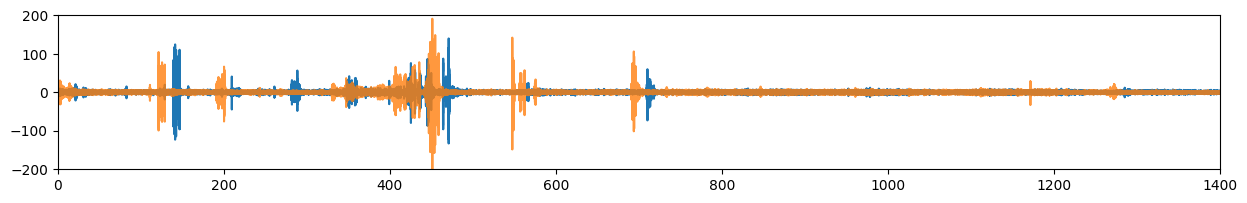

In [74]:
plt.figure(figsize=(15, 2))
plt.plot(same_times, prodigy_clipped_data)
plt.ylim(-200, 200)
plt.plot(same_times, 0.8*idun_clipped_data, alpha = 0.8)
plt.xlim(0, 1400)
plt.ylim(-200, 200)

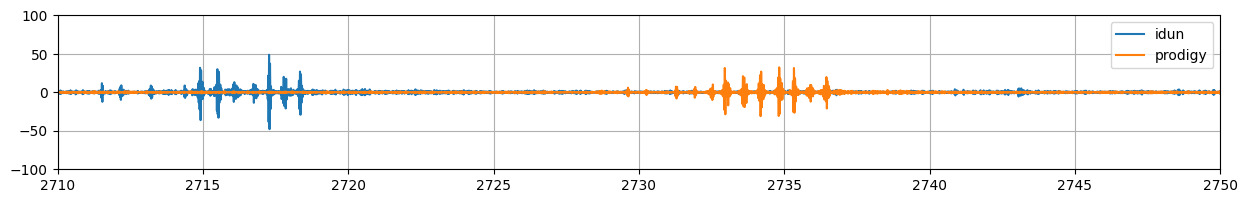

In [75]:
plt.figure(figsize=(15, 2))
plt.plot(same_times,idun_clipped_data, label='idun')
plt.plot(same_times,0.5*prodigy_clipped_data, label='prodigy')
plt.xlim(2710, 2750)
plt.legend()
plt.ylim(-100,100)
plt.grid()

### Calculate lag

In [76]:
# extract only the first 1000 seconds
prodigy_clipped_temp_data = copy.deepcopy(prodigy_clipped_data[:20*60*config.BASE_SAMPLE_RATE])
idun_clipped_temp_data = copy.deepcopy(idun_clipped_data[:20*60*config.BASE_SAMPLE_RATE])

prodigy_epochs = epoch_data(prodigy_clipped_temp_data, config.FIRST_LAG_EPOCH_SIZE)
idun_epochs = epoch_data(idun_clipped_temp_data, config.FIRST_LAG_EPOCH_SIZE)
# extract only the f

In [77]:
correlation_arr, max_corr_arr, lag_arr = calculate_epochs_lag(prodigy_epochs, idun_epochs)
lag_arr_copy = lag_arr[1:].copy()

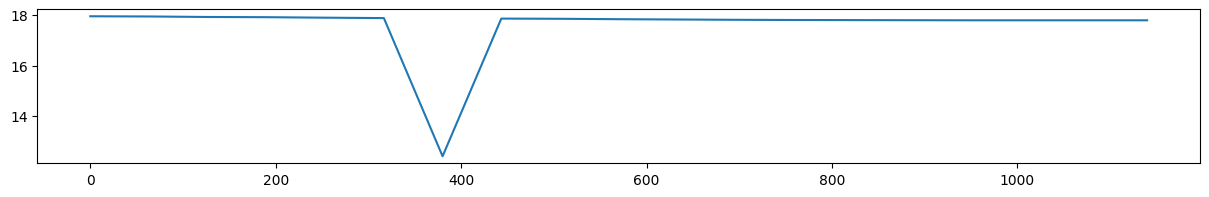

In [78]:

plt.figure(figsize=(15, 2))
# create a time array based on config.FIRST_LAG_EPOCH_SIZE and length of lag_arr_copy
plot_time_arr = np.linspace(0, len(lag_arr_copy)*config.FIRST_LAG_EPOCH_SIZE, len(lag_arr_copy))
# convert  to seconds
plot_time_arr = plot_time_arr/config.BASE_SAMPLE_RATE
plt.plot(plot_time_arr,np.array(lag_arr_copy)/250)
plt.show()

### Cut based on first analysis

In [79]:
lag_arr = np.array(lag_arr)
lag_initial = lag_arr[:20]
lag_initial = remove_outliers(lag_initial)
lag_mean = lag_initial[0]

# cut the lag_mean data from the start of idun_clipped_data if it is positive or from the start of  if negative
if lag_mean < 0:
    idun_cut_data = idun_clipped_data[lag_mean:]
    idun_base_cut_data = idun_base_clipped_data[lag_mean:]
    prodigy_cut_data = prodigy_clipped_data[:-(lag_mean)]
    prodigy_base_cut_df = prodigy_base_clipped_df[:-(lag_mean)].reset_index(drop=True)
else:
    idun_cut_data = idun_clipped_data[:-(lag_mean)]
    idun_base_cut_data = idun_base_clipped_data[:-(lag_mean)]
    prodigy_cut_data = prodigy_clipped_data[lag_mean:]
    prodigy_base_cut_df = prodigy_base_clipped_df[lag_mean:].reset_index(drop=True)

lag_mean:  17.96


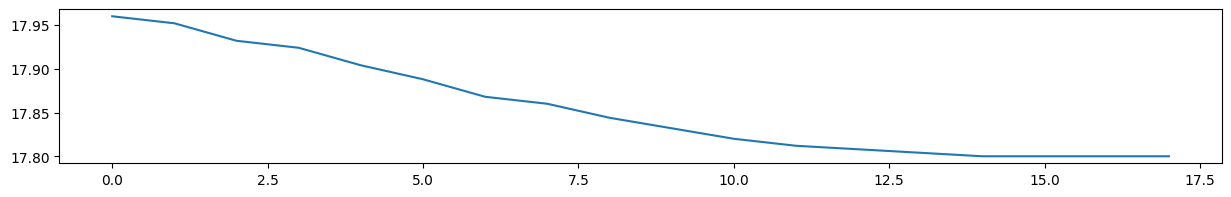

In [80]:
# plot the data
plt.figure(figsize=(15, 2))
plt.plot(lag_initial/250, label='idun')
print('lag_mean: ', lag_mean/250)

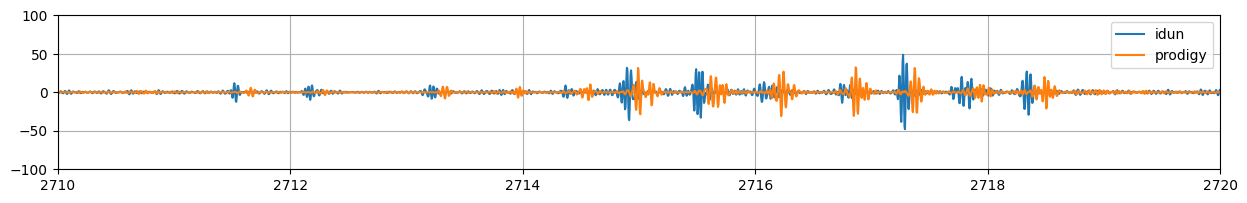

In [81]:
# plot the data
plt.figure(figsize=(15, 2))
time_seconds = np.arange(len(idun_cut_data))/config.BASE_SAMPLE_RATE
plt.plot(time_seconds,idun_cut_data, label='idun')
plt.plot(time_seconds,0.5*prodigy_cut_data, label='prodigy')
plt.xlim(2710, 2720)
plt.legend()
plt.ylim(-100,100)
plt.grid()

### Do a more fine grained sync

In [82]:

cutted_prodigy_epochs = epoch_data(prodigy_cut_data, config.SECOND_LAG_EPOCH_SIZE)
cutted_idun_epochs = epoch_data(idun_cut_data, config.SECOND_LAG_EPOCH_SIZE)

In [83]:
fine_correlation_arr, fine_max_corr_arr, fine_lag_arr = calculate_epochs_lag(cutted_prodigy_epochs, cutted_idun_epochs)

(-1.0, 5.0)

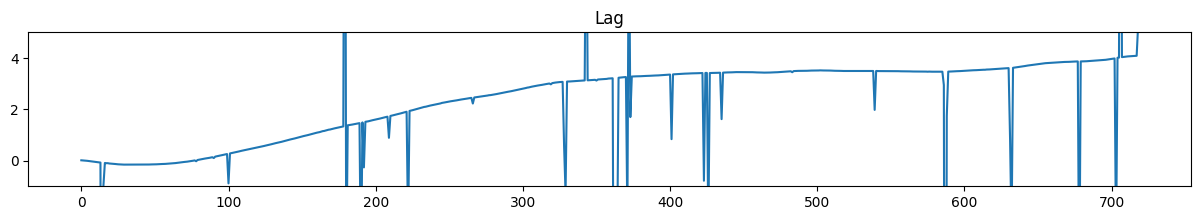

In [84]:
fine_lag_arr_copy = fine_lag_arr.copy()
plt.figure(figsize=(15, 2))
plt.plot(np.array(fine_lag_arr_copy)/250)
plt.title('Lag')
plt.ylim(-1,5)

### Do some cleaning on lag estimation

In [85]:
cleaned_fine_lag_arr = replace_outliers(fine_lag_arr_copy)

(-1.0, 5.0)

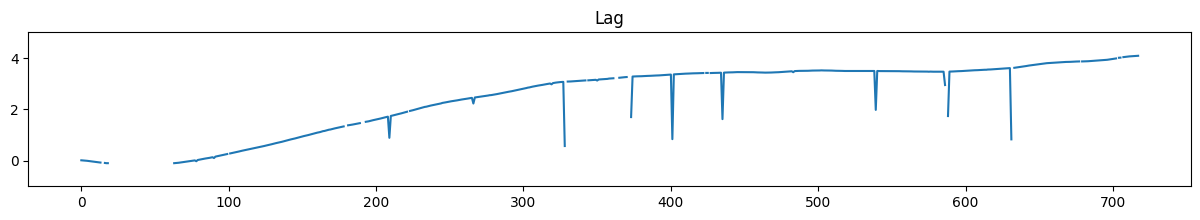

In [64]:
plt.figure(figsize=(15, 2))
plt.plot(np.array(cleaned_fine_lag_arr)/250)
plt.title('Lag')
plt.ylim(-1,5)

### Fit a curve to the data

In [86]:
original_raw_lag = copy.deepcopy(cleaned_fine_lag_arr)
x_axis_lag = np.arange(len(cleaned_fine_lag_arr)).reshape(-1, 1)
x_axis_lag_copy = x_axis_lag.copy()
# find where y is not nan
not_nan_idx = np.where(~np.isnan(original_raw_lag))[0]
original_raw_lag = original_raw_lag[not_nan_idx]
x_axis_lag = x_axis_lag[not_nan_idx]
# Transform the features to 2nd degree polynomial features
poly = PolynomialFeatures(degree=5)
X_poly = poly.fit_transform(X)
# Create a LinearRegression model and fit it to the polynomial features
reg = LinearRegression().fit(X_poly, original_raw_lag)
# Predict values
X_new_poly = poly.transform(x_axis_lag_copy)
linear_regression_lag = reg.predict(X_new_poly)

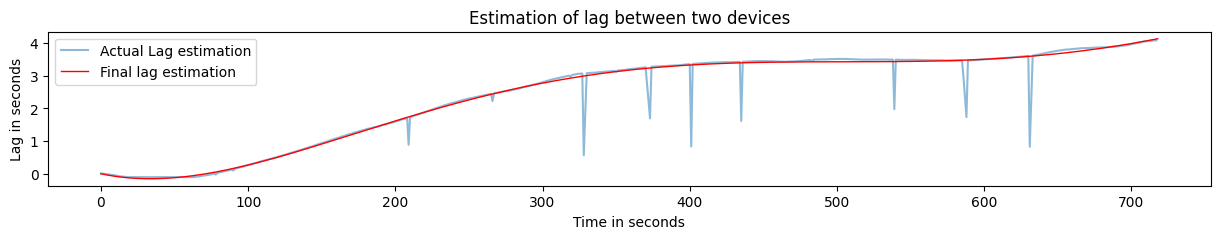

In [87]:
# Plotting the regression curve
plt.figure(figsize=(15, 2))
plt.plot(X, original_raw_lag/250, label='Actual Lag estimation', alpha=0.5)
plt.plot(X_copy, linear_regression_lag/250, "r-", label="Final lag estimation", linewidth=1)
plt.title("Estimation of lag between two devices")
plt.xlabel("Time in seconds")
plt.ylabel("Lag in seconds")
plt.legend()
plt.show()

### Create linear knots

In [92]:
x_axis_simulated = np.linspace(0, len(linear_regression_lag)-1, len(linear_regression_lag))  # This will be 0 to 718
x_knots = np.linspace(0, len(linear_regression_lag)-1, config.TOTAL_LINEAR_SEGMENTS+1)
y_knots = linear_regression_lag[(x_knots).astype(int)]  # Directly get the y-values from y_pred

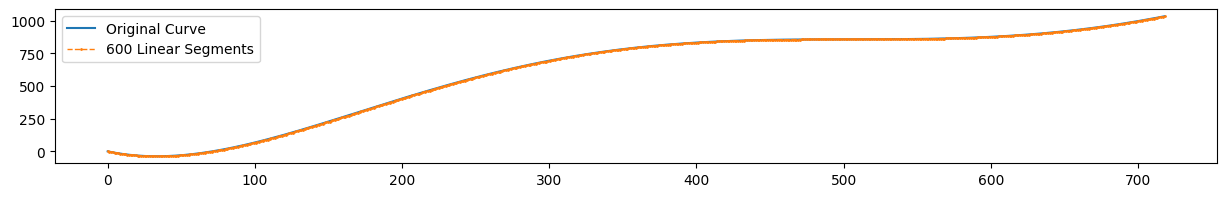

In [93]:
# Plot
plt.figure(figsize=(15, 2))
plt.plot(x_axis_simulated, linear_regression_lag, label='Original Curve')
plt.plot(x_knots, y_knots, label=f'{config.TOTAL_LINEAR_SEGMENTS} Linear Segments', linestyle='--', marker='o', linewidth=1, markersize=1)
plt.legend()
plt.show()

### Use the Linear lines to estimate the difference in sampling rates and apply

In [94]:
point_size = config.SECOND_LAG_EPOCH_SIZE
adjustment_epoch_size = int(len(prodigy_cut_data)/config.TOTAL_LINEAR_SEGMENTS)
lag_positions = np.arange(0, len(prodigy_cut_data), adjustment_epoch_size)
cumulative_lags = y_knots.astype(int)
lag_sizes = np.diff(cumulative_lags)

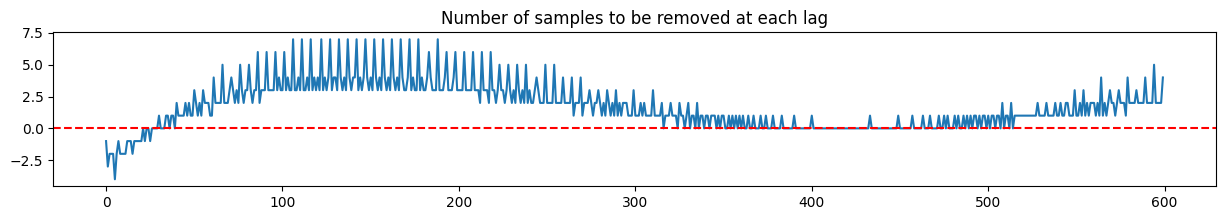

In [98]:
plt.figure(figsize=(15, 2))
plt.plot(lag_sizes)
plt.title("Number of samples to be removed at each lag")
plt.axhline(y=0, color='r', linestyle='--')

In [25]:
dataset2 = copy.deepcopy(prodigy_cut_data)
dataset2_list = dataset2.tolist()

for i in range(len(lag_positions)):
    start_index = lag_positions[i]
    # Calculate how many elements to replace with np.nan
    if i == 0:
        n_replace = int(cumulative_lags[i])
    else:
        n_replace = int(cumulative_lags[i] - cumulative_lags[i-1])
    # For debugging
    print(f"Replacing {n_replace} values from position {start_index}.")
    
    for j in range(n_replace):
        if start_index+j < len(dataset2_list):
            dataset2_list[start_index+j] = np.nan

# Convert back to numpy array and remove np.nan values
adjusted_dataset2 = np.array(dataset2_list)
adjusted_dataset2 = adjusted_dataset2[~np.isnan(adjusted_dataset2)]

prodigy_adjusted_final_arr = adjusted_dataset2
idun_adjusted_final_arr = idun_cut_data

# Cut from the end of the longer dataset
if len(prodigy_adjusted_final_arr) > len(idun_cut_data):
    prodigy_adjusted_final_arr = prodigy_adjusted_final_arr[:len(idun_adjusted_final_arr)]
else:
    idun_adjusted_final_arr = idun_adjusted_final_arr[:len(prodigy_adjusted_final_arr)]

print(len(prodigy_adjusted_final_arr), len(idun_adjusted_final_arr))


Replacing 0 values from position 0.
Replacing -1 values from position 8992.
Replacing -3 values from position 17984.
Replacing -2 values from position 26976.
Replacing -2 values from position 35968.
Replacing -2 values from position 44960.
Replacing -4 values from position 53952.
Replacing -2 values from position 62944.
Replacing -1 values from position 71936.
Replacing -2 values from position 80928.
Replacing -2 values from position 89920.
Replacing -2 values from position 98912.
Replacing -2 values from position 107904.
Replacing -1 values from position 116896.
Replacing -1 values from position 125888.
Replacing -1 values from position 134880.
Replacing -2 values from position 143872.
Replacing -1 values from position 152864.
Replacing -1 values from position 161856.
Replacing -1 values from position 170848.
Replacing -1 values from position 179840.
Replacing -1 values from position 188832.
Replacing 0 values from position 197824.
Replacing -1 values from position 206816.
Replacing 0

In [26]:
final_prodigy_epochs = epoch_data(prodigy_adjusted_final_arr, config.SECOND_LAG_EPOCH_SIZE)
final_idun_epochs = epoch_data(idun_adjusted_final_arr, config.SECOND_LAG_EPOCH_SIZE)

In [27]:
final_correlation_arr, final_max_corr_arr, final_lag_arr = calculate_epochs_lag(final_prodigy_epochs, final_idun_epochs)

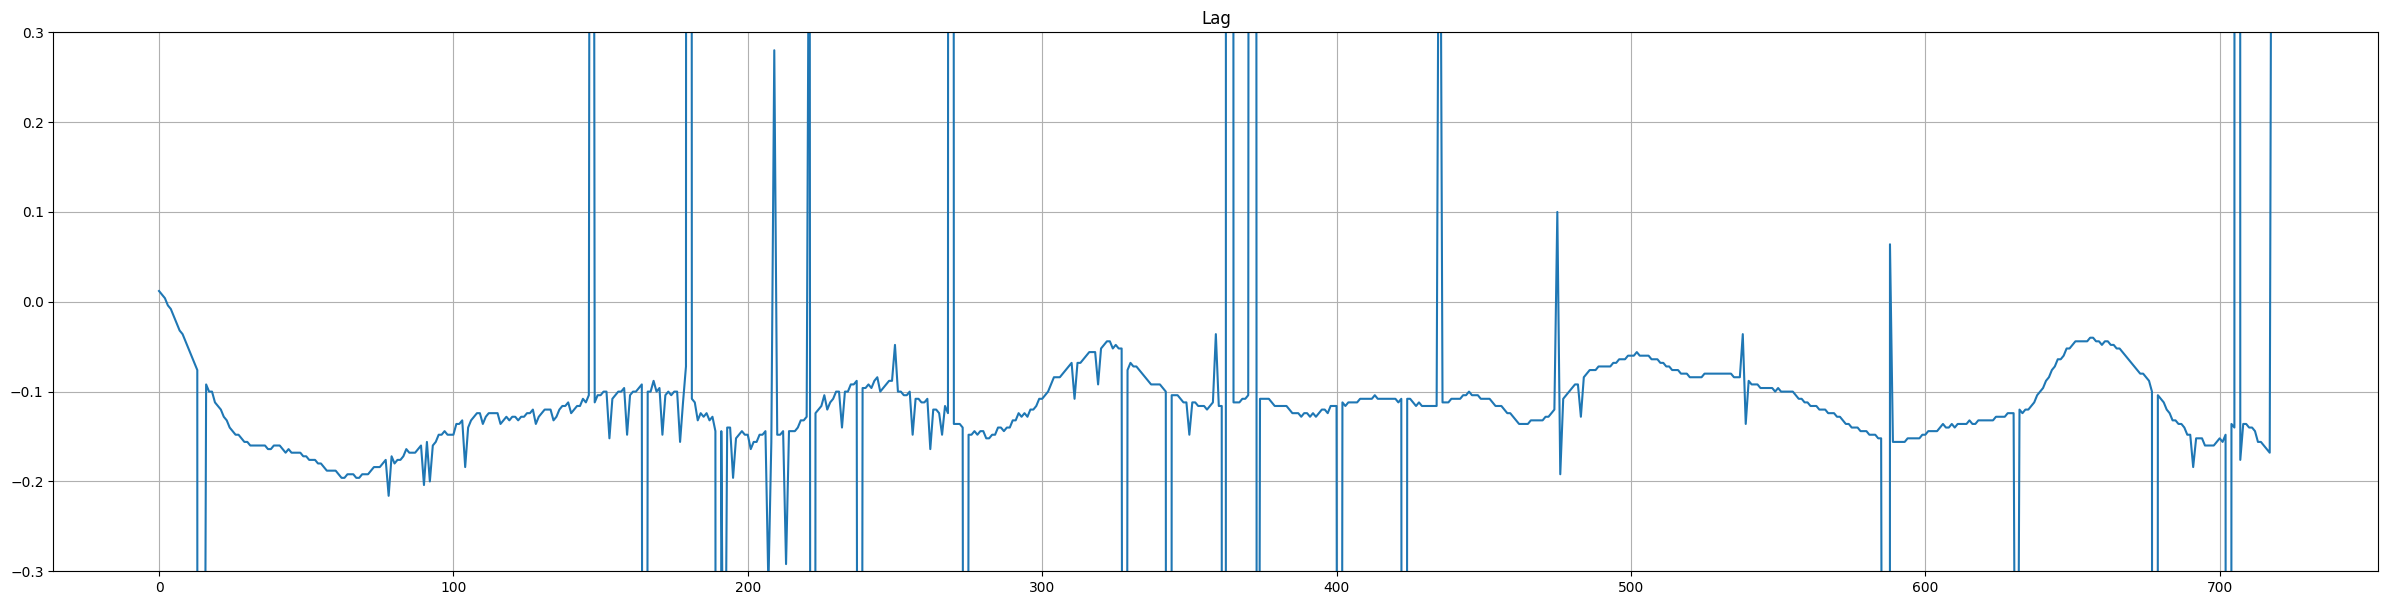

In [28]:
final_lag_arr_copy = final_lag_arr.copy()
plt.figure(figsize=(30, 7))
plt.plot(np.array(final_lag_arr)/250)
plt.title('Lag')
plt.ylim(-0.3,0.3)
plt.grid()

### Clean the lags

In [29]:
cleaned_final_lag_arr = replace_outliers(final_lag_arr_copy)
# rfind where the values are nan
nan_idx = np.argwhere(np.isnan(cleaned_final_lag_arr))
# remove the nan values
mean_final_lag = np.mean(np.delete(cleaned_final_lag_arr, nan_idx, axis=0))

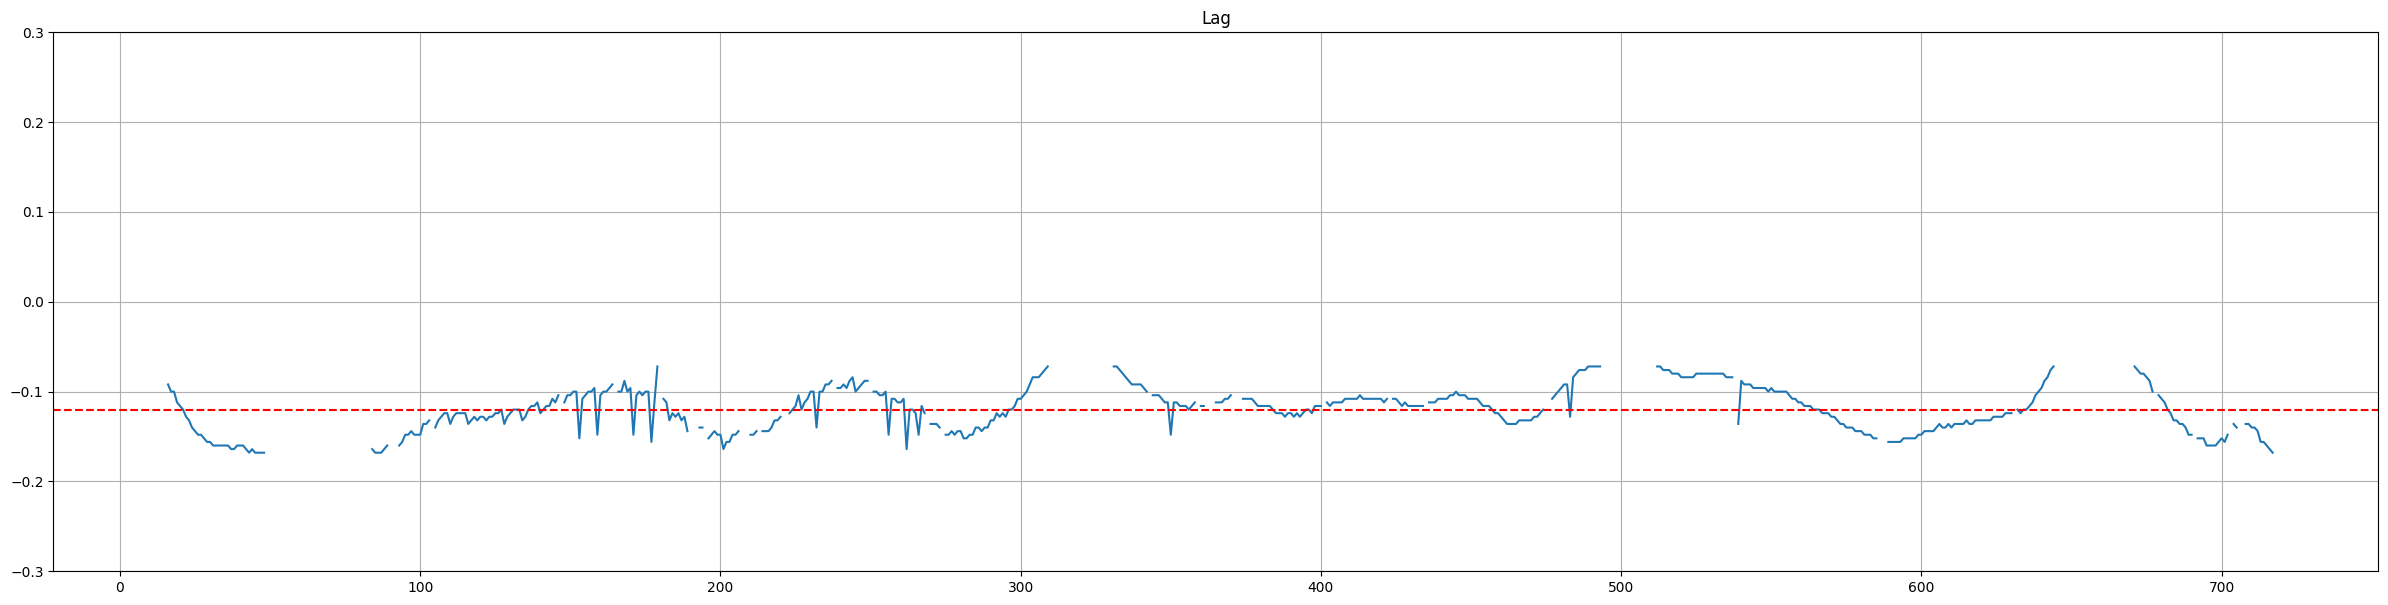

In [30]:
plt.figure(figsize=(30, 7))
plt.plot(np.array(cleaned_final_lag_arr)/250)
# plot the mean_final_lag as a horizontal line
plt.axhline(y=mean_final_lag/250, color='r', linestyle='--')
plt.title('Lag')
plt.ylim(-0.3,0.3)
plt.grid()

### Remove this final shift

In [31]:
# remove mean amount from start of idun data if negative else from start of prodigy data if positive
if mean_final_lag > 0:
    shifted_final_prodigy_arr = prodigy_adjusted_final_arr[int(mean_final_lag):]
    shifted_final_idun_arr = idun_adjusted_final_arr[:int(mean_final_lag)]
else:
    shifted_final_prodigy_arr = prodigy_adjusted_final_arr[:-(-int(mean_final_lag))]
    shifted_final_idun_arr = idun_adjusted_final_arr[-int(mean_final_lag):]


In [32]:
shifted_final_prodigy_epochs = epoch_data(shifted_final_prodigy_arr, config.SECOND_LAG_EPOCH_SIZE)
shifted_final_idun_epochs = epoch_data(shifted_final_idun_arr, config.SECOND_LAG_EPOCH_SIZE)
shifted_final_correlation_arr, shifted_final_max_corr_arr, shifted_final_lag_arr = calculate_epochs_lag(shifted_final_prodigy_epochs, shifted_final_idun_epochs)

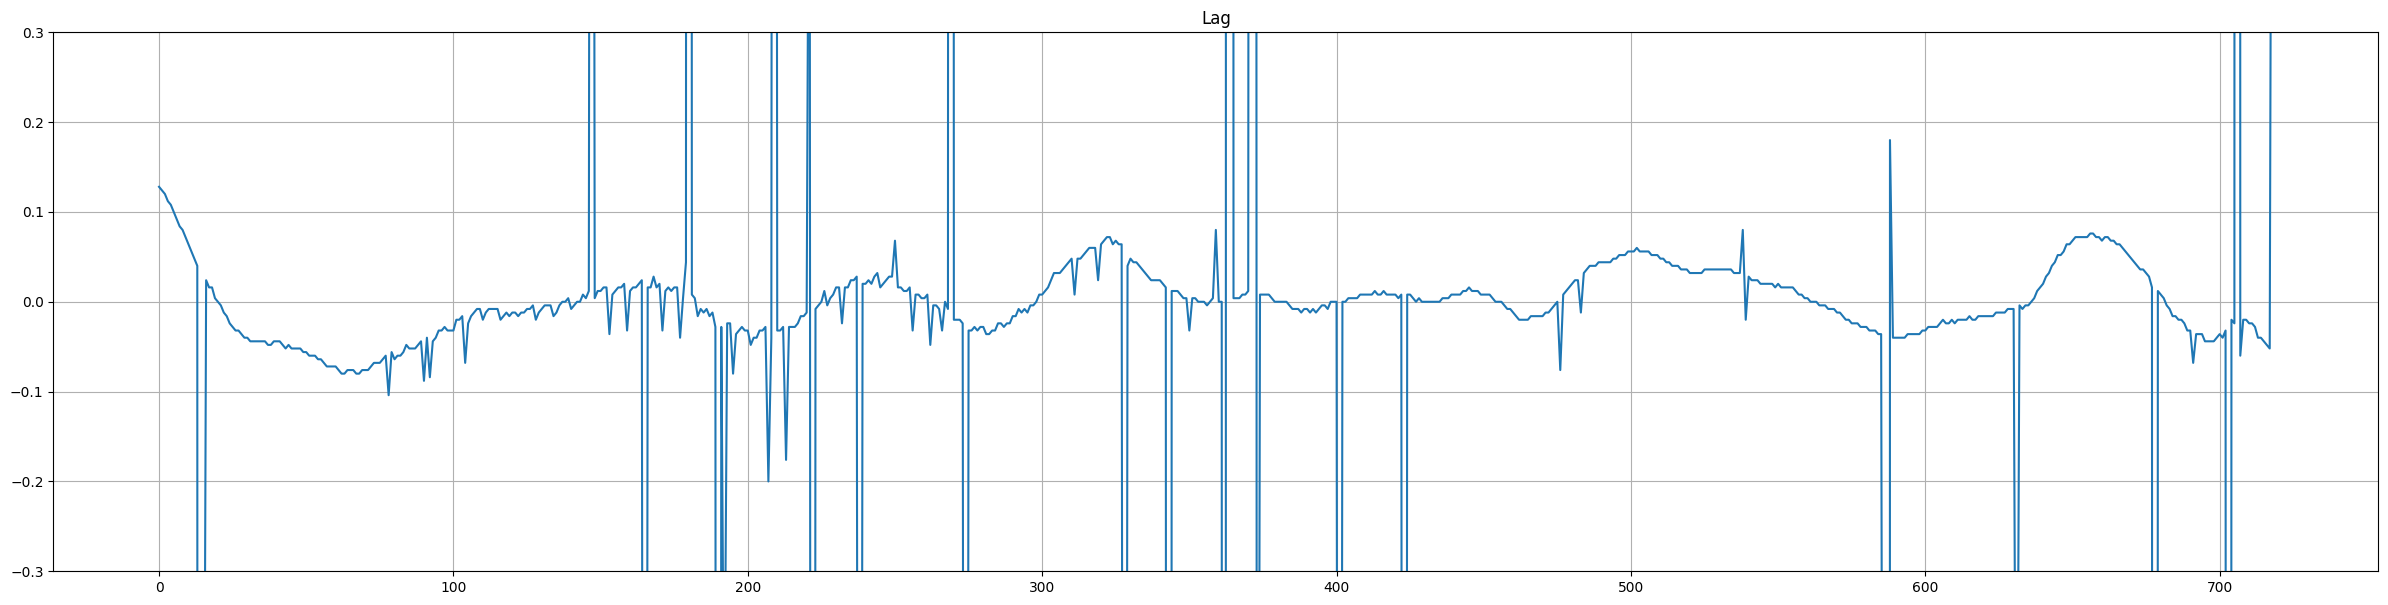

In [33]:

plt.figure(figsize=(30, 7))
plt.plot(np.array(shifted_final_lag_arr)/250)
plt.title('Lag')
plt.ylim(-0.3,0.3)
plt.grid()

### Plot final data

/Users/waddaben/.local/share/virtualenvs/idn-sync-data-pWEap7XJ/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/waddaben/.local/share/virtualenvs/idn-sync-data-pWEap7XJ/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


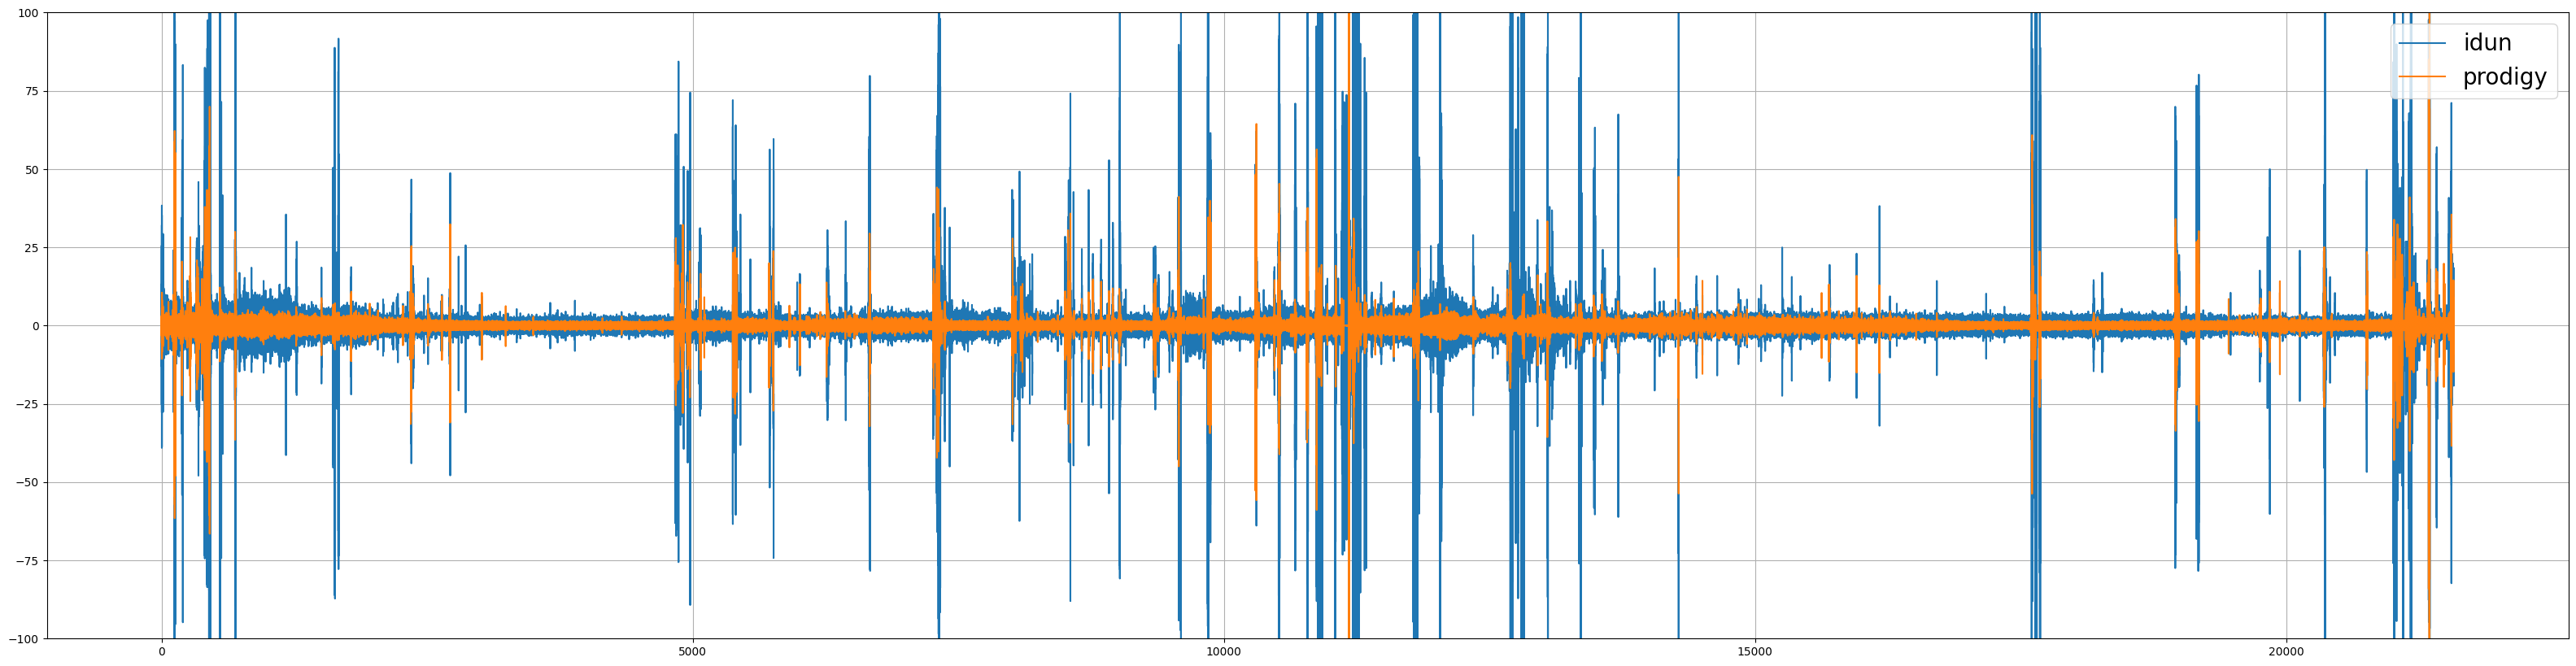

In [34]:
plt.figure(figsize=(40, 10))
# create a seconds axis
time_seconds = np.arange(len(shifted_final_idun_arr))/config.BASE_SAMPLE_RATE
plt.plot(time_seconds,shifted_final_idun_arr, label='idun')
plt.plot(time_seconds,0.5*shifted_final_prodigy_arr, label='prodigy')
plt.legend(fontsize=20)
plt.ylim(-100,100)
plt.grid()

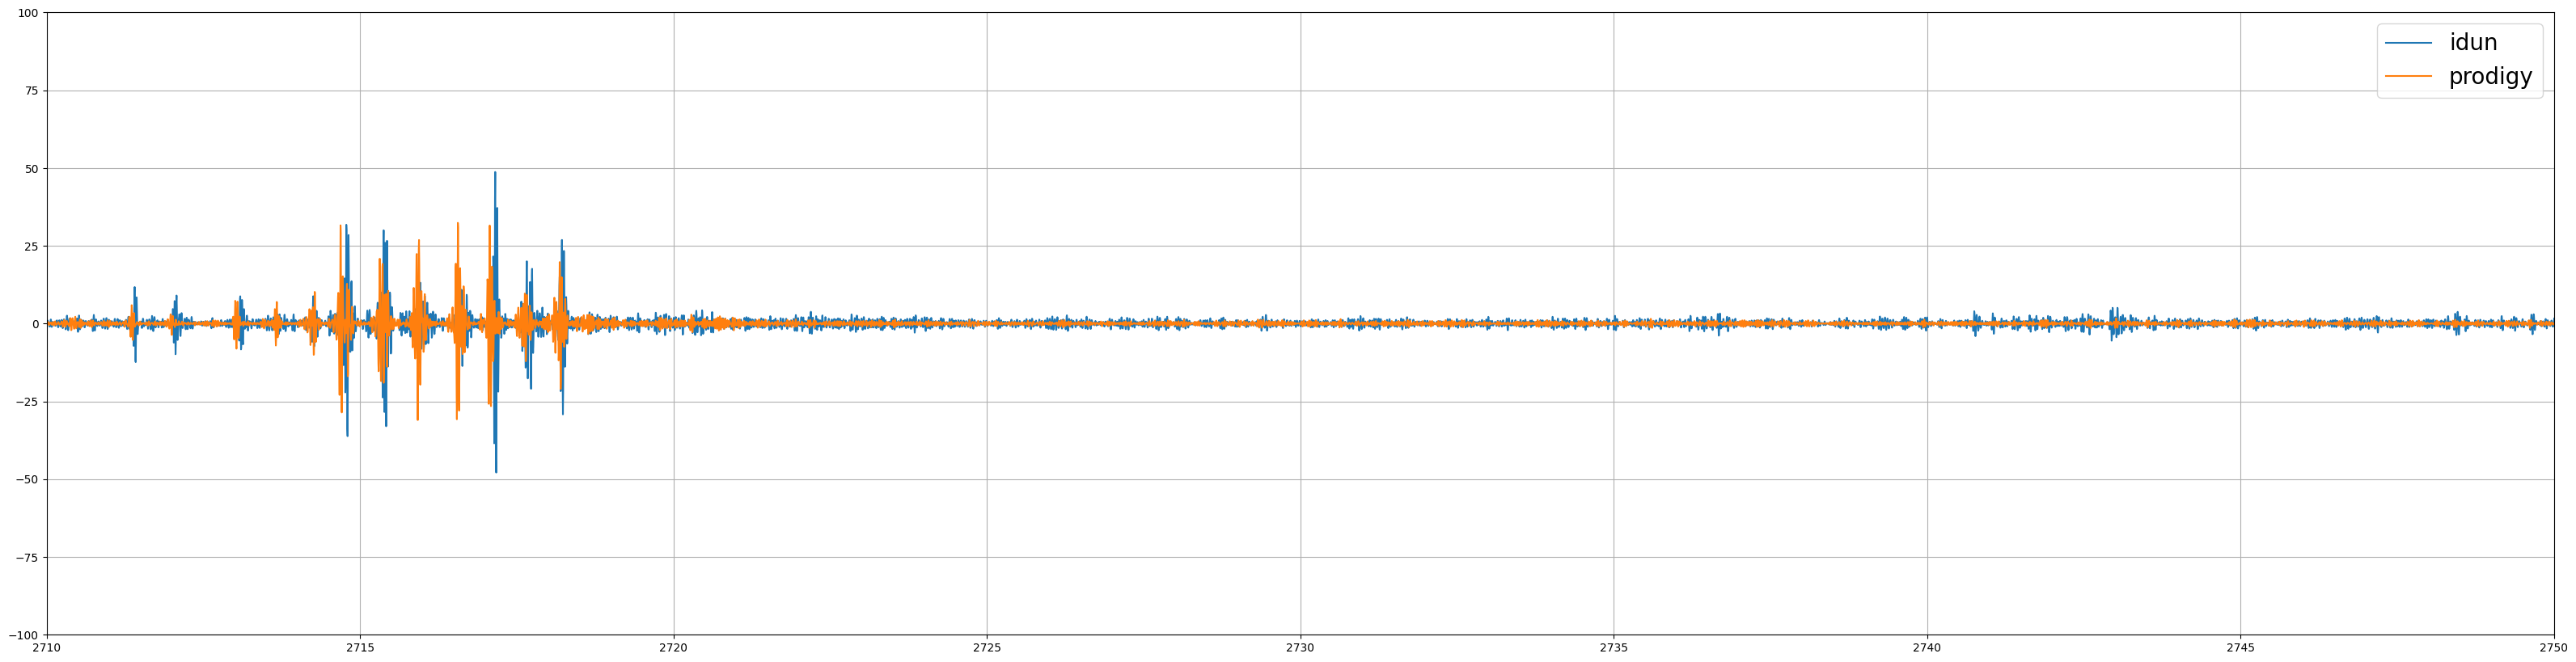

In [36]:
plt.figure(figsize=(40, 10))
# create a seconds axis
shift = 0
time_seconds = np.arange(len(shifted_final_idun_arr))/config.BASE_SAMPLE_RATE
plt.plot(time_seconds,shifted_final_idun_arr, label='idun')
plt.plot(time_seconds,0.5*shifted_final_prodigy_arr, label='prodigy')
plt.legend(fontsize=20)
plt.xlim(2710, 2750)
plt.ylim(-100,100)
plt.grid()